In [1]:
import os
from datetime import datetime

import torch
from torch import nn
from torchvision import datasets
import torchvision.transforms.v2 as transforms_v2
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torcheval.metrics.functional import (
    multiclass_accuracy,
    multiclass_f1_score
)
from dl_utils import train_one_epoch, test, plot_predictions


In [2]:
####################
# Hyperparameters
####################
learning_rate = 1e-4    # TODO: Change this as you see fit
batch_size = 64         # TODO: Change this as you see fit
epochs = 5              # TODO: Change this as you see fit


In [3]:
####################
# Dataset
####################
# Define a transform
train_trans = transforms_v2.Compose([
    # TODO: Try to add/edit/remove other realistic transformation for training
    # See more from this link: https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html
    transforms_v2.ToImage(),  # Convert to tensor (C, H, W), only needed if you had a PIL image
    transforms_v2.RandomResizedCrop(size=(224, 224), antialias=True),
    transforms_v2.RandomHorizontalFlip(p=0.5),
    transforms_v2.ToDtype(torch.float32, scale=True),    # Converts the input to a type float32, and rescale from [0, 255] to [0, 1]
    transforms_v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize a tensor with mean and standard deviation.
])

test_trans = transforms_v2.Compose([
    transforms_v2.ToImage(),  # Convert to tensor (C, H, W), only needed if you had a PIL image
    transforms_v2.Resize(256),  # Resize to have the smallest dimension of 72 while maintaining aspect ratio
    transforms_v2.CenterCrop(224),  # Center crop an image to be 64x64
    transforms_v2.ToDtype(torch.float32, scale=True),    # Converts the input to a type float32, and rescale from [0, 255] to [0, 1]
    transforms_v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize a tensor with mean and standard deviation.
])

In [4]:
# TODO: Define DataSet for train, valid, and test
data_dir = '.\data\THFOOD50-v1'
print(f"Data directory: {data_dir}")

Data directory: .\data\THFOOD50-v1


In [5]:
torch.manual_seed(42)

train_ds = datasets.ImageFolder(
    root=os.path.join(data_dir, "train"),
    transform= train_trans 
)

valid_ds = datasets.ImageFolder(
    root=os.path.join(data_dir, "val"),
    transform= test_trans
)
valid_ds, test_ds = random_split(valid_ds, [0.8, 0.2])

# Dataset sizes
print(f"Train set: {len(train_ds)} samples")
print(f"Valid set: {len(valid_ds)} samples")
print(f"Test set: {len(test_ds)} samples")


Train set: 14168 samples
Valid set: 1280 samples
Test set: 320 samples


In [6]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [7]:
####################
# Model
####################
# Detect computing device on your computer
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
    
# Import the model class from model.py
from torchvision.models import resnet50, ResNet50_Weights

# Create a model
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_ds.classes))
model = model.to(device)

Using cuda device


Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) (1): True
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (2): True
ReLU(inplace=True) (3): True
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) (4): True
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256,

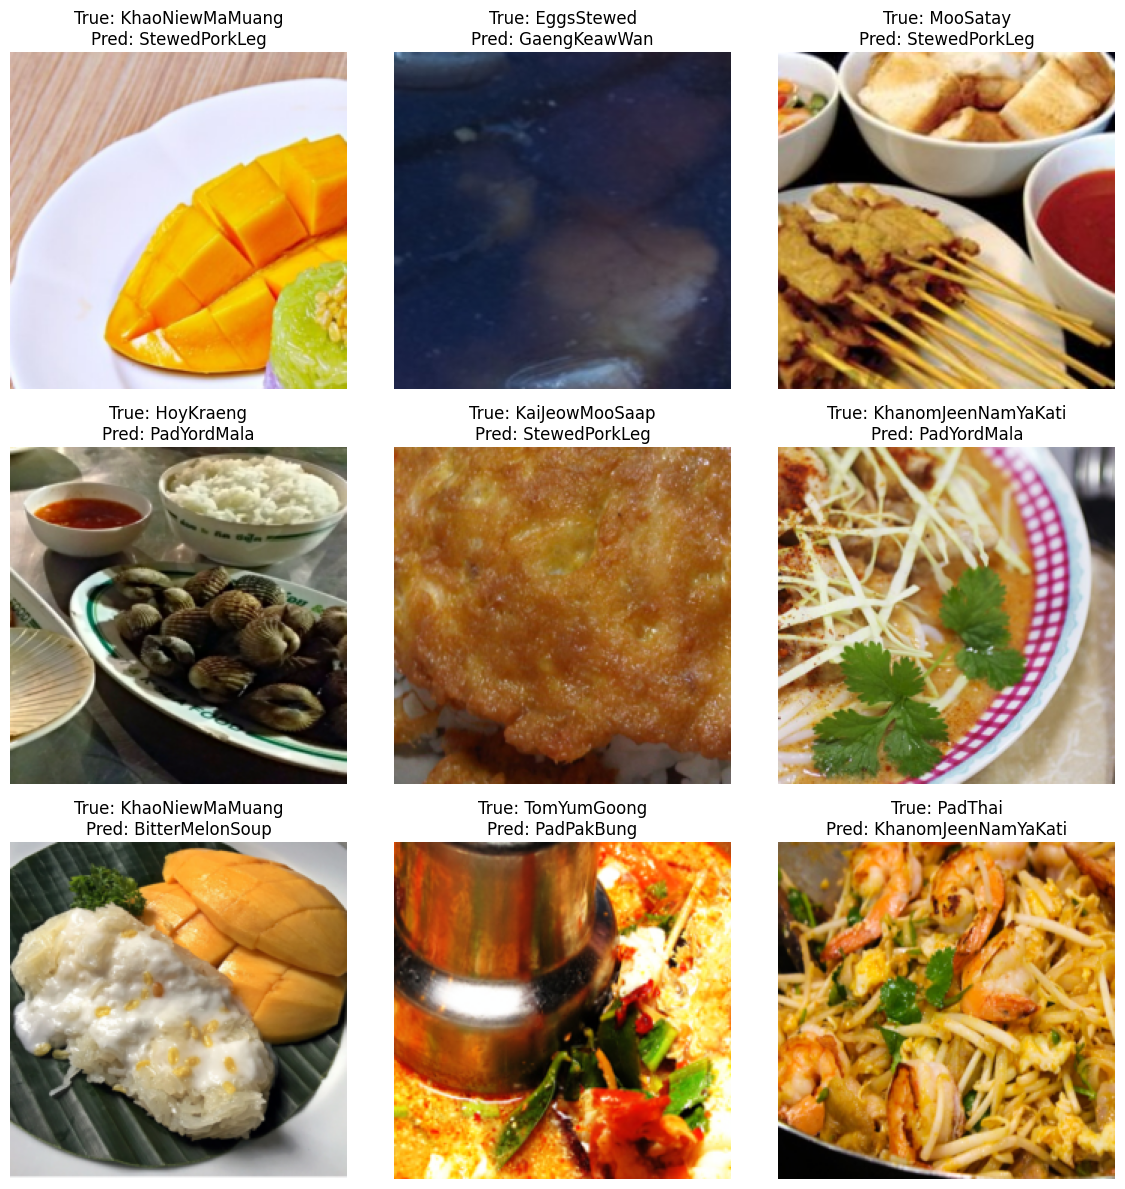

In [8]:
# TODO: Set `fine_tune_at` to specify how many layers to freeze
# Note: 
# - The lower the `fine_tune_at` value, the more layers are fine-tuned (or trained) from that layer onward until the last layer.
#     - `fine_tune_at=1` means you want to finetune all layers.
# - The number of layers varies depending on the model choice.
fine_tune_at = 1
ct = 0
for child in model.children():
    ct += 1
    if ct < fine_tune_at:
        for param in child.parameters():
            param.requires_grad = False
        print(f"{child} ({ct}): {False}")
    else:
        for param in child.parameters():
            param.requires_grad = True
        print(f"{child} ({ct}): {True}")

# Try to feed `batch_x` into the model to test the forward pass
batch_x, batch_y = next(iter(train_dl))
y_hat = model(batch_x.to(device))
y_pred = torch.argmax(y_hat, dim=1)  # this is optional
print(y_hat)
print(y_pred)  # this is optional

plot_predictions(batch_x, batch_y, y_pred, train_ds.classes)

In [9]:
####################
# Model Training
####################
# Setup tensorboard
writer = SummaryWriter(f'./runs/trainer_{model._get_name()}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

In [10]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

In [11]:
# Specify optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [12]:
# Training loop
best_vloss = 100000.
for epoch in range(epochs):
    print(f"Epoch {epoch+1} / {epochs}")
    train_one_epoch(train_dl, model, loss_fn, optimizer, epoch, device, writer, log_step_interval=1)
    train_loss, train_y_preds, train_y_trues = test(train_dl, model, loss_fn, device)
    val_loss, val_y_preds, val_y_trues = test(valid_dl, model, loss_fn, device)
    
    # Performance metrics
    train_perf = {
        'accuracy': multiclass_accuracy(train_y_preds, train_y_trues).item(),
        'f1': multiclass_f1_score(train_y_preds, train_y_trues).item(),
    }
    
    # Performance metrics
    val_perf = {
        'accuracy': multiclass_accuracy(val_y_preds, val_y_trues).item(),
        'f1': multiclass_f1_score(val_y_preds, val_y_trues).item(),
    }
    
    # Log model training performance
    writer.add_scalars('Train vs. Valid/loss', 
        {'train':train_loss, 'valid': val_loss}, 
        epoch)
    writer.add_scalars(
        'Performance/acc', 
        {'train':train_perf['accuracy'], 'valid': val_perf['accuracy']},
        epoch)
    writer.add_scalars(
        'Performance/f1', 
        {'train':train_perf['f1'], 'valid': val_perf['f1']},
        epoch)

    # Track best performance, and save the model's state
    if val_loss < best_vloss:
        best_vloss = val_loss
        torch.save(model.state_dict(), 'model_best_vloss.pth')
        print('Saved best model to model_best_vloss.pth')
print("Done!")

Epoch 1 / 5
loss: 3.927581  [   64/14168]


KeyboardInterrupt: 

In [13]:
###########################
# Evaluate on the Test Set
###########################
# TODO: Load the best model
model_best = model
model_best.load_state_dict(torch.load('model_best_vloss.pth'))
model_best.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'model_best_vloss.pth'

In [ ]:
# TODO: Use the best model on the training set
train_loss, train_y_preds, train_y_trues = test(train_dl, model_best, loss_fn,device)

# Performance metrics on the training set
train_perf = {
    'accuracy': multiclass_accuracy(train_y_preds, train_y_trues).item(),
    'f1': multiclass_f1_score(train_y_preds, train_y_trues).item(),
}

# TODO: Use the best model on the test set
test_loss, test_y_preds, test_y_trues = test(test_dl, model_best, loss_fn,device)


# Performance metrics
test_perf = {
    'accuracy': multiclass_accuracy(test_y_preds, test_y_trues).item(),
    'f1': multiclass_f1_score(test_y_preds, test_y_trues).item(),
}

print(f"Train: loss={train_loss:>8f}, acc={(100*train_perf['accuracy']):>0.1f}%, f1={(100*train_perf['f1']):>0.1f}%")
print(f"Test: loss={test_loss:>8f}, acc={(100*test_perf['accuracy']):>0.1f}%, f1={(100*test_perf['f1']):>0.1f}%")
